# Generating time series of surface mass balance

Now that we have aggregated surface mass balance to catchments, explored the data, and identified some good candidate temporal models, we are ready to generate time series of SMB.  We will apply a selected temporal model and a spatially-informed noise method to generate a range of SMB time series with variability that matches that presented in process models.


**EDITS**:
- 21 Aug 23: Implemented `hold_back` argument to ensure AR models of different orders (in different basins) are comparable, and to ensure their residuals can be computed.  This fixes the problem described below with NaNs and nonconvergence in empirical covariance matrix.
- 19 Aug 23: Updates to `fit_catchment_series` to test white noise (AR(0)); enable varying best_n across catchments.  Note that this *does not work* right now, covariance does not converge.  Return to this.
- 16 AUG 23: Generate plots with RACMO as the comparison model rather than ANICE, as requested by a reviewer.
- 27-28 DEC 22: Read in catchment mean series rather than totals, and include all basins (range(0,260)) rather than only 1-200.

Author: Lizz Ultee

### Preliminaries

Make sure that you have activated your `stisp` environment, defined for conda installation in the `environment.yml` file of this repository.  All of the packages we import here should be available within that environment.

In [210]:
from sklearn.covariance import GraphicalLassoCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from statsmodels.tsa.ar_model import AutoReg
import scipy.linalg
import glob

Adjust matplotlib default settings for plot label sizes and color scheme:

In [211]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

noise_colors=cm.get_cmap('Blues')

We do all of our stochastic fitting to the output from individual process models, because fitting a multi-model mean would damp out some of the variability that we want to capture.  Data is aggregated to catchments defined by Mouginot & Rignot (link), tagged with ID numbers consistent with that dataset.  Here we select a process model to emulate and a glacier catchment to examine.

In [255]:
model_names = ['ANICE-ITM_Berends', 'CESM_kampenhout', 'dEBM_krebs','HIRHAM_mottram', 
                'NHM-SMAP_niwano', 'RACMO_noel', 'SNOWMODEL_liston']

highlight_model = model_names[0]
highlight_catchment_name, highlight_catchment_id = 'KANGERLUSSUAQ', 101

Now, we define some helper functions.  `read_catchment_series` will read in our aggregated data from CSV, `fit_catchment_series` will test several orders of AR(n) model and report which is the best fit to the data, and `find_AR_residuals` returns the residuals from a selected AR(n) model fit, which we will need for the spatial covariance method.

In [256]:
## Read in time series
def read_catchment_series(fpath, anomaly=True):
    catchment_fpath = fpath
    catchment_tseries = pd.read_csv(catchment_fpath, index_col=0, parse_dates=[0])
    catchment_tseries.mask(catchment_tseries>1e30)
    anomaly_series = catchment_tseries - catchment_tseries.mean()
    if anomaly:
        return anomaly_series
    else:
        return catchment_tseries

def fit_catchment_series(tseries, which_model, comparison_n=range(1,6), hold_back=None,
                         seasonal=True):
    bic_per_n = pd.DataFrame(index=comparison_n, columns=model_names)
    
    if 'multi' in which_model:  ## allow multi-model mode reporting
        for m in model_names:
            for n in comparison_n:
                mod = AutoReg(tseries[m], n, trend='ct', seasonal=seasonal,
                             hold_back=hold_back)
                results = mod.fit()
                bic_per_n[m][n] = results.bic
            bic_per_n[m] = pd.to_numeric(bic_per_n[m])
        best_n = bic_per_n.idxmin().mode()[0]
    else:
        for n in comparison_n:
            mod = AutoReg(tseries[which_model], n, trend='ct', seasonal=seasonal,
                         hold_back=hold_back)
            results = mod.fit()
            bic_per_n[which_model][n] = results.bic
        bic_per_n[which_model] = pd.to_numeric(bic_per_n[which_model])
        best_n = bic_per_n[which_model].idxmin()
    
    bic_difference = bic_per_n.transform(lambda x: x-x.min())
    
    return best_n, bic_difference

def find_AR_residuals(tseries, which_model, chosen_n=1, 
                         seasonal=False, hold_back=None):
    mod = AutoReg(tseries[which_model], chosen_n, trend='ct', seasonal=seasonal,
                 hold_back=hold_back)
    results = mod.fit()
    resids = results.resid
    
    return resids

## Time series from AR(n) fits

First, we read in process-model-derived time series of SMB for the selected catchment, from all process models.  We resample the monthly data to annual sums with `pandas.Series.resample('A').sum()`.  

We identify the best autoregressive model according to the most common best-fit among all process models, so that we can enforce some consistency later on.  You can easily change this by moving the fit into the `for` loop and setting `which_model=m` rather than `multi`.

Finally, we fit an autoregressive model to each process model's output using `statsmodels.tsa.ar_model.AutoReg().fit()`, and we save the fitted AR models to a dictionary indexed by process-model name.

In [257]:
import warnings
warnings.filterwarnings(action='ignore')

We ignore warnings for now, because statsmodels is going to complain about parameter names.  This does not affect our results.  If you are debugging and want to see warnings, you can set `action=once` instead.

In [258]:
## Time series from AR(n) fits
mod_fits = {m: [] for m in model_names}
mods = {m: [] for m in model_names}

ctmt_fpath = glob.glob('/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP-processed/*-catchment_{}_mean-tseries.csv'.format(highlight_catchment_id))[0]
s = read_catchment_series(ctmt_fpath, anomaly=True)
a = s.resample('A').sum()
best_n, _ = fit_catchment_series(a, which_model='multi', seasonal=False, hold_back=5)
for m in model_names:
    mod = AutoReg(a[m], best_n, trend='ct', seasonal=False).fit()
    fv = mod.fittedvalues
    r = mod.resid
    mod_fits[m] = fv
    mods[m] = mod

In [259]:
best_n

4

Now we have our dictionary `mods` that stores AR models trained on process model output.  The elements of `mods` are `AutoRegResults` objects.  We can use the built-in method `predict` to generate several realizations of stochastic surface mass balance that approximate a given process model's series.

In [260]:
n_realizations = 10
preds = []
for k in range(n_realizations):
    mod = mods[highlight_model]
    ar_smb_k = mod.predict(best_n, len(a)-1, dynamic=True)
    preds.append(ar_smb_k)

Note that we ask `predict` to use dynamic prediction (not using the input data values) after a short initial period.  You can experiment with different lengths of the initial period, but if you do not set the `dynamic` argument, the default behavior is that `predict` uses all available input values.  See the [statsmodels documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoRegResults.predict.html#statsmodels.tsa.ar_model.AutoRegResults.predict) for more details.

Let's plot the AR(n) realizations in `preds` and compare them with the SMB process model output.

<Figure size 640x480 with 0 Axes>

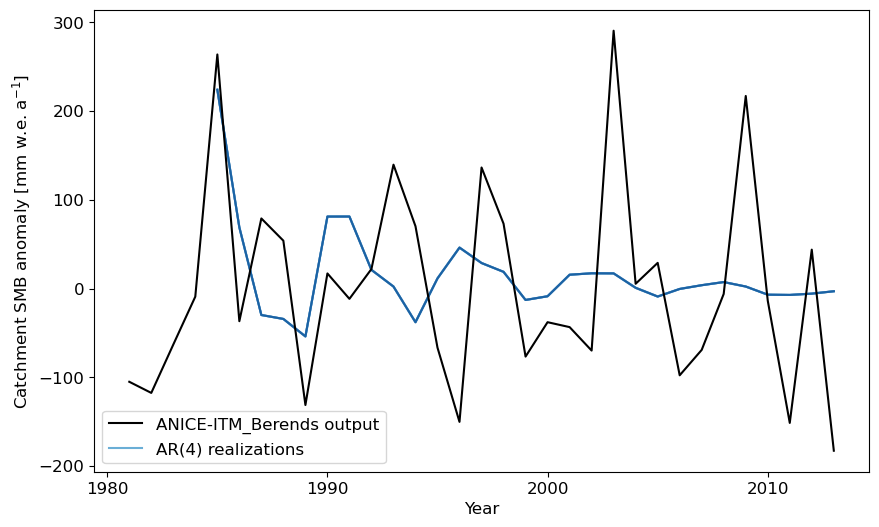

In [261]:
plt.clf()
fig1, ax1 = plt.subplots(figsize=(10,6))
for k in range(n_realizations):
    ax1.plot(preds[k], 
            color=noise_colors(k/n_realizations), alpha=0.5)
ax1.plot(a[highlight_model], color='k',
         label='{} output'.format(highlight_model))
ax1.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='AR({}) realizations'.format(best_n))
ax1.set(xlabel='Year', ylabel=r'Catchment SMB anomaly [mm w.e. a$^{-1}$]',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010))
ax1.legend(loc='best')
plt.show()

Notice that we have included multiple "realizations" above, but they all appear to coincide.  This is because we are generating only the best-fit temporal model series, and not including the noise term $\epsilon(t)$.  We now turn our attention to the noise terms.

## Noise with spatial information

Now, we will find a sparse correlation matrix for _all_ catchments, fit with the same order of AR model, to a single process model's SMB output.

First we find and store the residuals of the AR fit to each catchment.  Then we find the empirical correlation matrix `emp_C`.  

In [262]:
ar_resids = []
ts_toplot = []

# best_n=1 ## experiment with setting it manually
for i in range(0, 260):
    # print(i)
    ctmt_fpath = glob.glob('/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP-processed/*-catchment_{}_mean-tseries.csv'.format(i))[0]
    s = read_catchment_series(ctmt_fpath, anomaly=True)
    a = s.resample('A').sum()
    if a.isna().sum().sum()>0:
        print('NaNs found in catchment {}'.format(i))
        continue
    else:
        ts_toplot.append(a)
        best_n, _ = fit_catchment_series(a, which_model=highlight_model, comparison_n=range(1,6),
                                         seasonal=False, hold_back=5)
        r = find_AR_residuals(a, which_model=highlight_model, chosen_n=best_n, 
                              seasonal=False, hold_back=5)
        ar_resids.append(r)

# ar_resids -= np.mean(ar_resids, axis=0) # normalize
# emp_C = np.corrcoef(ar_resids)
df = pd.DataFrame(ar_resids) 
## for some reason was getting "Operands could not be broadcast together" -- so make DF
df_normd = df - df.mean(axis=0)
emp_C = np.corrcoef(df_normd) 

In [263]:
np.shape(emp_C)

(260, 260)

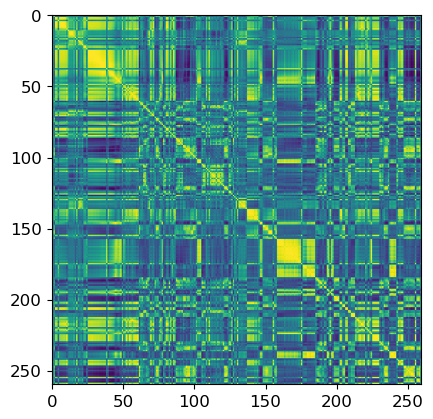

In [264]:
plt.imshow(emp_C)

In [265]:
np.sum(np.isnan(emp_C))

0

For our case, where we have ~30 years of data for 260 catchments, the empirical correlation matrix is unstable and contains too much information.  We use `sklearn.GraphicalLassoCV()` to find a sparse correlation matrix that approximates it and tamps down some of the spurious features.

In [266]:
np.random.seed(0)
X = np.random.multivariate_normal(mean=np.zeros(len(df)), cov=emp_C, size=len(df.iloc[0]))

gl_model = GraphicalLassoCV()
gl_model.fit(X)
cov_ = gl_model.covariance_

Now, following Hu \& Castruccio (2021 preprint), we generate noise series for each catchment using the sparse covariance matrix (in Cholesky lower-triangular decomposition) and the diagonal matrix of standard deviations of the individual catchments' AR residuals.  Here, the noise series will be the same length as `ar_resids`, representing however many years are in the training set.

In [267]:
L = scipy.linalg.cholesky(cov_, lower=True)
N = np.random.normal(size=np.shape(ar_resids)) # draws from normal dist

D = np.diag(np.std(ar_resids,1)) ## diagonal matrix of standard devs
# scaled_noise = D @ L @ N

noise_realizations = []
for j in range(n_realizations):
    Nj = np.random.normal(size=np.shape(ar_resids))
    noise_j = D @ L @ Nj
    noise_realizations.append(noise_j[highlight_catchment_id-1])

Plot the noise realizations alone:

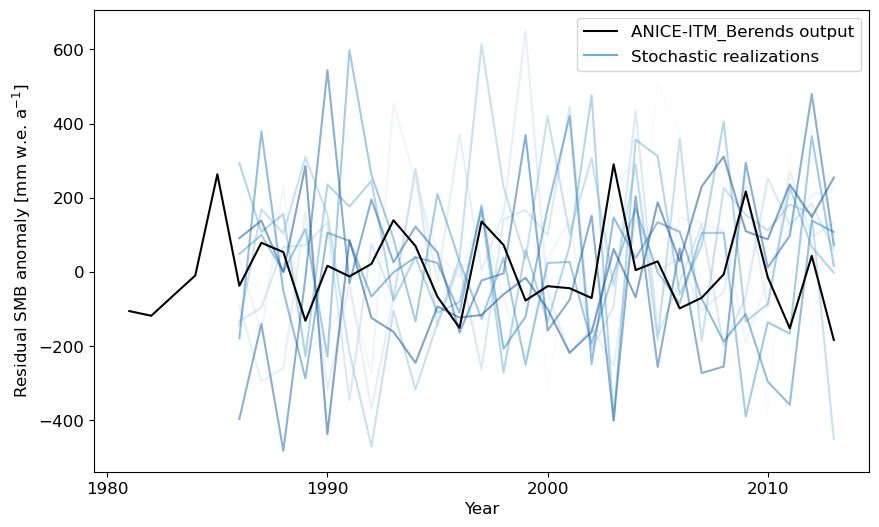

In [268]:
## Plot noise and process model residual
held_back = 5 

fig2, ax2 = plt.subplots(figsize=(10,6))
for k in range(n_realizations):
    ax2.plot(a.index[held_back::], noise_realizations[k], 
            color=noise_colors(k/n_realizations), alpha=0.5)
ax2.plot(ts_toplot[highlight_catchment_id][highlight_model], color='k', ## previously used highlight_catchment_id-1 as index, but now we also read in catchment 0, so the -1 is not needed.
         label='{} output'.format(highlight_model))
ax2.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
ax2.set(xlabel='Year', ylabel=r'Residual SMB anomaly [mm w.e. a$^{-1}$]',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010))
ax2.legend(loc='best')
plt.show()

In [269]:
len(noise_realizations[0])

28

## A full stochastic model of SMB

We can put together the AR(n) series and the spatially informed noise to generate "full" realizations of SMB.  For example:

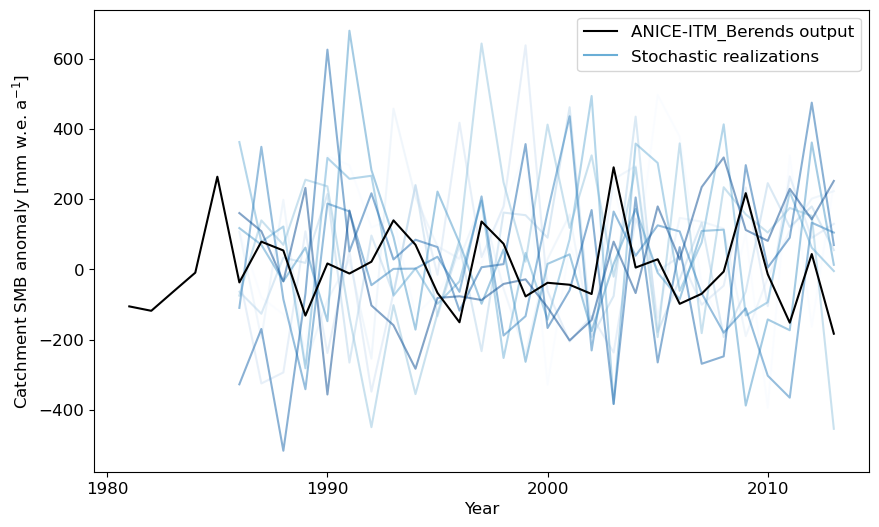

In [270]:
## Plot a sum of the two
fig3, ax3 = plt.subplots(figsize=(10,6))
for k in range(n_realizations):
    ax3.plot(mods[highlight_model].predict(best_n, len(a)-1, dynamic=best_n)[held_back-1::]
             +noise_realizations[k], 
            color=noise_colors(k/n_realizations), alpha=0.5)
ax3.plot(ts_toplot[highlight_catchment_id][highlight_model], color='k',
         label='{} output'.format(highlight_model))
ax3.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
ax3.set(xlabel='Year', ylabel=r'Catchment SMB anomaly [mm w.e. a$^{-1}$]',
        xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
                np.datetime64('2000-01-01'), np.datetime64('2010-01-01')),
        xticklabels=(1980,1990,2000,2010))
ax3.legend(loc='best')
plt.show()

In [271]:
len(mods[highlight_model].predict(best_n, len(a)-1, dynamic=best_n))

32

We can even forecast SMB into the future with this combination.  Simply choose how many years of output should be created, feed this information to `predict`, and perform another matrix multiplication to generate noise series of the appropriate length.

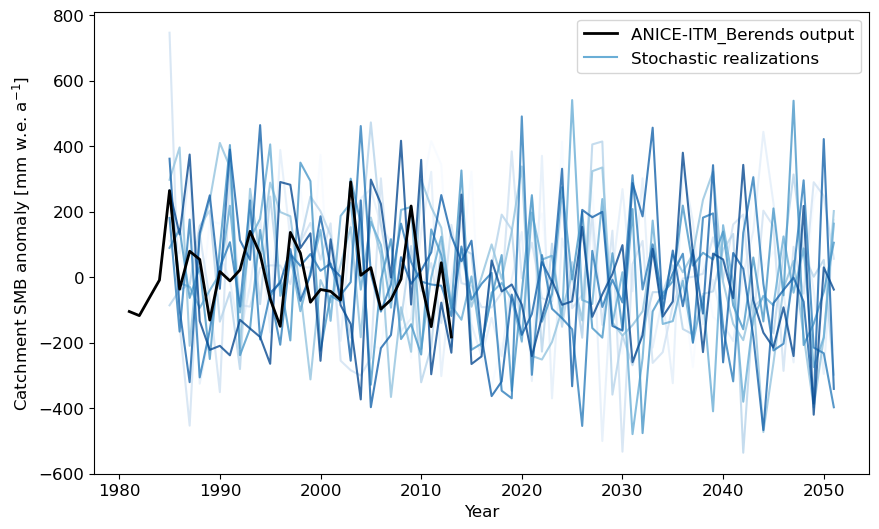

In [272]:
## Future forecast
yrs_after_1980 = 70
noise_into_future = []
preds_into_future = []
for j in range(n_realizations):
    ar_smb_k = mods[highlight_model].predict(best_n, yrs_after_1980, dynamic=True)
    preds_into_future.append(ar_smb_k)
    Nj = np.random.normal(size=(len(ar_resids), yrs_after_1980))
    noise_j = D @ L @ Nj
    noise_into_future.append(noise_j[highlight_catchment_id-1])

fig4, ax4 = plt.subplots(figsize=(10,6))
for k in range(n_realizations):
    ax4.plot(preds_into_future[k]
             +noise_into_future[k][best_n-1::], 
            color=noise_colors(k/n_realizations), lw=1.5, 
             alpha=0.8)
ax4.plot(ts_toplot[highlight_catchment_id][highlight_model], 
         color='k', lw=2.0,
         label='{} output'.format(highlight_model))
ax4.plot(np.NaN, np.NaN, color=noise_colors(0.5), label='Stochastic realizations')
ax4.set(xlabel='Year', ylabel=r'Catchment SMB anomaly [mm w.e. a$^{-1}$]')
# ax4.set(xticks=(np.datetime64('1980-01-01'), np.datetime64('1990-01-01'),
#                 np.datetime64('2000-01-01'), np.datetime64('2010-01-01'),
#                 np.datetime64('2020-01-01'), np.datetime64('2030-01-01'),
#                 np.datetime64('2040-01-01'), np.datetime64('2050-01-01'),),
#         xticklabels=(1980,1990,2000,2010,2020,2030,2040,2050))
ax4.legend(loc='best')
plt.show()

## 27 Aug 2022 - Covariance plots

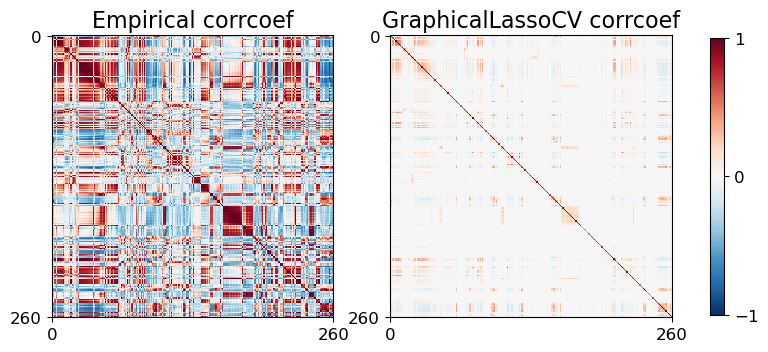

In [273]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
# plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_C),
        ('GraphicalLassoCV', cov_)]
# vmax = cov_.max()
vmax = 1
for i, (name, this_cov) in enumerate(covs):
    ax = axs.ravel()[i]
    # plt.subplot(1,2, i + 1)
    c = ax.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
                cmap=plt.cm.RdBu_r)
    ax.set(xticks=(0,260),
          yticks=(0,260),
          title='%s corrcoef' % name
          )
cb = fig.colorbar(c, ax=axs.ravel().tolist(), ticks=(-1,0,1),
                  location='right', shrink=0.6)
# plt.tight_layout()

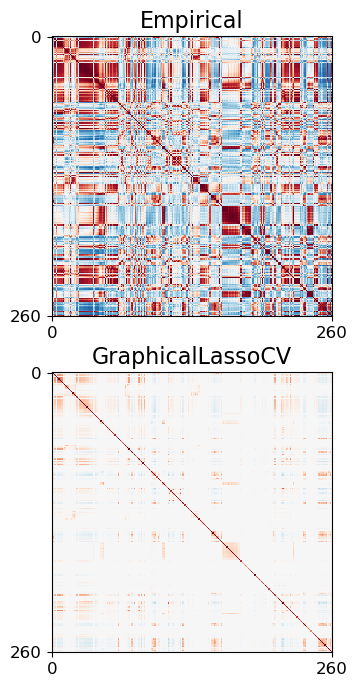

In [356]:
## 28 Aug - stack these to make composite, remove colorbar
fig, axs = plt.subplots(2,1, figsize=(6,8))
# plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_C),
        ('GraphicalLassoCV', cov_)]
# vmax = cov_.max()
vmax = 1
for i, (name, this_cov) in enumerate(covs):
    ax = axs.ravel()[i]
    # plt.subplot(1,2, i + 1)
    c = ax.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
                cmap=plt.cm.RdBu_r)
    ax.set(xticks=(0,260),
          yticks=(0,260),
          title='%s' % name
          )
    ax.title.set_size(16)
    ax.xaxis.label.set_size(18)
# cb = fig.colorbar(c, ax=axs.ravel().tolist(), ticks=(-1,0,1),
#                   location='right', shrink=0.6)
# plt.tight_layout()

In [274]:
cov_.min()

-0.30264862857236785

Add the map view?

No, we'll need to import other data to show the map view.  Make a separate notebook.

In [306]:
import shapefile
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm, colors, colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [281]:
## Read in BedMachine surface to evaluate
gl_bed_path ='/Users/lizz/Documents/GitHub/Data_unsynced/BedMachine-Greenland/BedMachineGreenland-2017-09-20.nc'
fh = Dataset(gl_bed_path, mode='r')
xx = fh.variables['x'][:].copy() #x-coord (polar stereo (70, 45))
yy = fh.variables['y'][:].copy() #y-coord
s_raw = fh.variables['surface'][:].copy() #surface elevation
thick_mask = fh.variables['mask'][:].copy()
ss = np.ma.masked_where(thick_mask !=2, s_raw)#mask values: 0=ocean, 1=ice-free land, 2=grounded ice, 3=floating ice, 4=non-Greenland land
fh.close()

X = xx[::4]
Y = yy[::4]
S = ss[::4, ::4]

In [282]:
## Read in Mouginot catchments from shapefile
print('Reading in Mouginot catchments')
catchment_fn = '/Users/lizz/Documents/GitHub/Data_unsynced/Greenland-catchments-Mouginot/Greenland_Basins_PS_v1.4.2.'
sf = shapefile.Reader(catchment_fn) 

Reading in Mouginot catchments


In [329]:
map_highlight_catchment_name, map_highlight_catchment_id = 'UMIAMMAKKU', 0


In [340]:
corr_cmap = cm.get_cmap('RdBu_r')
highlight_corrs = cov_[:,map_highlight_catchment_id]
norm = colors.Normalize(vmin=-1, vmax=1) ## re-scale if needed so that we can see the variations better

In [341]:
corr_cmap(norm(highlight_corrs.min()))

(0.8722029988465976, 0.9229527104959632, 0.9508650519031142, 1.0)

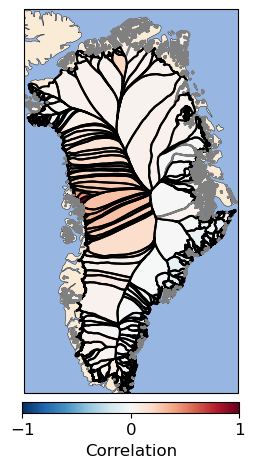

In [342]:
## New commands to remove bounding box
fig=plt.figure(figsize=(4,6)) ## was doubly defining 'ax' above; subplots command creates bounding box that figure does not

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45.0))
ax.set(xlim=(min(X)-100, max(X)+100), ylim=(min(Y)-100, max(Y)+100))
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, facecolor='antiquewhite') ## these do not match the land mask of bedmachine and smbmip
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)

for i,shape in enumerate(sf.shapeRecords()[0:260]):
    corr_with_highlight_ctmt = highlight_corrs[i]
    corr_color = corr_cmap(norm(corr_with_highlight_ctmt))
    if len(shape.shape.parts)>1:
        catchment_color='grey'
    else:
        catchment_color='k'
    for i in range(len(shape.shape.parts)): ## plot disjointed parts separately
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        x = [i[0] for i in shape.shape.points[i_start:i_end]]
        y = [i[1] for i in shape.shape.points[i_start:i_end]]
        ax.plot(x,y, color=catchment_color, transform=ccrs.epsg(3413))
        ax.fill(x,y, color=corr_color, transform=ccrs.epsg(3413))

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=corr_cmap),
             location='bottom', label='Correlation',
            pad=0.02, shrink=0.7)

cbar.ax.set(xticks=(-1, 0, 1))

plt.show()
# plt.savefig('/Users/lizz/Documents/Research/StISP/Figure-making/{}-Greenland_catchments_SMB_map-land_underlay'.format(date.today().strftime('%Y%m%d')), 
#             dpi=300, format='png')

In [346]:
from datetime import date 
fig.savefig('/Users/lizz/Documents/Research/StISP/Figure-making/{}-Map_sparse_covar-UMI_example'.format(date.today().strftime('%Y%m%d')), 
            dpi=300, format='png')